## Riksarkivet SBL  - Wikidata ett försök att synka dom
version 0.42

WD egenskap [Property:P3217](https://www.wikidata.org/wiki/Property:P3217) 
* den här [notebooken](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)   
  * SBL personartiklar som saknar [sv:Wikipedia artikel](https://w.wiki/c5f) < 150
* [SBL vs SKBL female articles](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  

SBL har idag
* personartiklar
* släktartiklar
  * en person i en släktartikel kan ha en sida som bara pekar till släktartikeln (med text ej länk)

Det saknas idag från Riksarkivet ett API så nedanstående är ett försök att webscrapa deras data och sedan försöka hitta en struktur. 

Målsättningen är att ha personerna som har en SBL personartikel representerade i Wikidata. Kul vore att även ha släktartiklarna kopplade till Wikidata... är inte säkert hur bra strukturen är för släkter/ätter/familjer i WD och sedan behövs det matchas en hel del. En person kan även omnämnas i en släktartikel och bör då i Wikidata ha "beskriven av källa" kopplad till dessa artiklar (exempel Gunnar Mossing [Q5994570#P1343](https://www.wikidata.org/wiki/Q5994570#P1343) som finns i artikel SBL ["Morssing, släkt"](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=9512)) vilket är ett mycket stort jobb om Riksarkivet inte går över till att leverera [länkade data](https://sv.wikipedia.org/wiki/L%C3%A4nkade_data)...     

**Mina gissningar** 
1. sida med född/död är en person
2. sida med titel släkt är en släktartikel
3. sida med född/död men för kort kan vara en referens till en släktartikel
4. släkt artikel kan ha "[ätt](https://sok.riksarkivet.se/sbl/Search.aspx?t=0)" i titeln men det kan visst även person artiklar ha
5. ....

### jmf SKBL med SBL 
med ett mera komplett Wikidata kan vi nu jämföra [Svenskt Kvinnobiografiskt lexikon - SKBL](https://www.skbl.se/sv/om-skbl) med [Riksarkivet](https://sok.riksarkivet.se/sbl/OmSBL.aspx) då det gäller urval av kvinnor, antal kvinnor, hur dom levererar, API vs. inte API, skillnaden att ha enbart svenska artiklar som SBL med att även ha [engelska artiklar som SKBL](https://www.skbl.se/en/about-skbl) 

* [Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)

# Webscrape 
1. vi gissar id min 4000 och max 40000


In [1]:
from datetime import datetime
now = datetime.now()
print("Last run: ", now)

Last run:  2020-09-17 06:49:48.910460


In [2]:
import urllib3, json
import pandas as pd   
from bs4 import BeautifulSoup
import sys
import pprint
http = urllib3.PoolManager()

from tqdm.notebook import trange  
listNewItems =[]

for SBLnr in trange(4000,40000): #gissar min 4000 max 40000
    url = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(SBLnr)
    r = http.request('GET', url) 
    if len(r.data) > 11020:
        new_item = dict()
        #print(SBLnr)
        new_item['SBLnr'] = SBLnr
        new_item['SBLlength'] = len(r.data)
        soup = BeautifulSoup(r.data, "html.parser")  
        
        try:
            titel = soup.findAll("span", {"id": "ctl00_MainContent_lblTitle"})[0].get_text()
            new_item['titel'] = titel
            #print ("\t",titel)
        except:
            pass
        try:
            Fodd = soup.findAll("span", {"id": "ctl00_MainContent_lblFodelse"})[0].get_text()
            #print ("\t",Fodd)
            new_item['Fodd'] = Fodd
        except:
            pass
        try:
            Dod = soup.findAll("span", {"id": "ctl00_MainContent_lblDod"})[0].get_text()
            #print ("\t",Dod)
            new_item['Dod'] = Dod
        except:
            pass
        try:
            band = soup.findAll("span", {"id": "ctl00_MainContent_lblBandSida"})[0].get_text()
            #print ("\t",band)
            new_item['Band'] = band
            try:
#                year = band.get_text().split("(")[1].split(")")
                year = band.split("(")[1].split(")")[0]
                #print ("\t\tYear",year)
                new_item['Year'] = year
            except:
                pass
        except:
            pass
            
        listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")
        



10127  antal poster


In [3]:
import csv
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SBL_newfile.csv", "w", newline='') as SBLfile:
        dict_writer = csv.DictWriter(SBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSBLcsv = pd.read_csv("SBL_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 

In [4]:
pd.set_option("display.max.rows", None) 

In [5]:
dfSBLcsv.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10127 non-null  int64 
 1   SBLlength  10127 non-null  int64 
 2   titel      10127 non-null  object
 3   Fodd       7081 non-null   object
 4   Dod        7563 non-null   object
 5   Band       10127 non-null  object
 6   Year       10111 non-null  object
dtypes: int64(2), object(5)
memory usage: 553.9+ KB


## Wikidata hämtar alla med P3217 satt 
dvs. även släkt kopplingar

In [6]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

querySKBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid WHERE {
?item wdt:P3217 ?sblid
}"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSBLtot = get_sparql_dataframe(endpoint_url, querySKBL)


In [7]:
WDSBLtot.sort_index(inplace=True)  

In [8]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wid     7670 non-null   object
 1   sblid   7670 non-null   object
dtypes: object(2)
memory usage: 120.0+ KB


In [9]:
%matplotlib inline    
import matplotlib.pyplot as plt   
plotSBLYear = dfSBLcsv["Year"].value_counts()


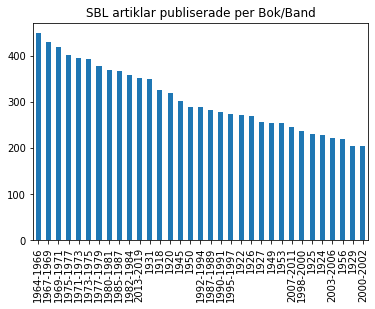

In [10]:
plotSBLYear.plot( kind = 'bar') 
plt.title("SBL artiklar publiserade per Bok/Band")
plt.show()

In [11]:
dfSBLcsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10127 non-null  int64 
 1   SBLlength  10127 non-null  int64 
 2   titel      10127 non-null  object
 3   Fodd       7081 non-null   object
 4   Dod        7563 non-null   object
 5   Band       10127 non-null  object
 6   Year       10111 non-null  object
dtypes: int64(2), object(5)
memory usage: 553.9+ KB


In [12]:
dfSBLcsv["url"] = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(dfSBLcsv["SBLnr"])

In [13]:
#dfFamily = dfSBLAuthorcsv.dropna()  
dfPerson = dfSBLcsv.dropna(subset = ['Fodd', 'Dod'])

In [14]:
dfPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7074 entries, 1 to 10125
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      7074 non-null   int64 
 1   SBLlength  7074 non-null   int64 
 2   titel      7074 non-null   object
 3   Fodd       7074 non-null   object
 4   Dod        7074 non-null   object
 5   Band       7074 non-null   object
 6   Year       7073 non-null   object
 7   url        7074 non-null   object
dtypes: int64(2), object(6)
memory usage: 497.4+ KB


In [15]:
dfFamily = dfSBLcsv[dfSBLcsv.isnull().any(1)]

In [16]:
dfFamily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 10126
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      3054 non-null   int64 
 1   SBLlength  3054 non-null   int64 
 2   titel      3054 non-null   object
 3   Fodd       8 non-null      object
 4   Dod        490 non-null    object
 5   Band       3054 non-null   object
 6   Year       3038 non-null   object
 7   url        3054 non-null   object
dtypes: int64(2), object(6)
memory usage: 214.7+ KB


In [17]:
dfFamily

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url
0,5490,12160,"Abelin, släkt",NaN,NaN,"Band 01 (1918), sida 1.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
5,5495,19055,Abraham Brodersson,NaN,Död:1410-08-27,"Band 01 (1918), sida 12.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
6,5496,13280,"Abrahamson, släkt",NaN,NaN,"Band 01 (1918), sida 15.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
11,5501,117417,Abrahamus Andreæ Angermannus,NaN,Död:1607/08,"Band 01 (1918), sida 24.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
12,5502,11049,"Abramson, Erik Leonard",NaN,NaN,"Band 01 (1918), sida 15.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
14,5504,12571,"Achrelius, släkt",NaN,NaN,"Band 01 (1918), sida 40.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
16,5506,11069,"Achrelius, Ericus Danielis",NaN,NaN,"Band 01 (1918), sida 40.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
21,5511,14471,"Acrelius, släkt",NaN,NaN,"Band 01 (1918), sida 56.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
25,5516,12351,"Adelborg, släkt",NaN,NaN,"Band 01 (1918), sida 63.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
30,5521,12842,"Adelcrantz, släkt",NaN,NaN,"Band 01 (1918), sida 67.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...


In [18]:
dfFamilySlakt = dfFamily[dfFamily.titel.str.contains("släkt")]
#dfFamilySlakt

In [19]:
dictFamily = dfFamilySlakt.to_dict()

In [20]:
dfFamily.titel.str.contains("släkt").sum()

1722

In [21]:
dfFamily.titel.str.contains("ätten").sum()

37

In [22]:
dfFamily.titel.str.contains("Släkt").sum()

1

In [23]:
dfFamily.Dod.str.contains("senas").sum()

22

In [24]:
dfFamily[dfFamily.Dod.str.contains("senas", na=False)]

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url
1288,7679,17513,Olaus lambatunga,NaN,Död:senast 1206,"Band 28 (1992-1994), sida 130.",1992-1994,https://sok.riksarkivet.se/sbl/Presentation.as...
2156,9095,33783,Margareta,NaN,Död:senast 1130,"Band 25 (1985-1987), sida 141.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...
2302,9351,19448,Ruprecht Miller,NaN,Död:senast 1630,"Band 25 (1985-1987), sida 506.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...
3753,11708,20561,Kol,NaN,Död:senast 1172/73,"Band 21 (1975-1977), sida 467.",1975-1977,https://sok.riksarkivet.se/sbl/Presentation.as...
3785,11749,17582,Mårten Krakow,NaN,Död:senast 1616,"Band 21 (1975-1977), sida 525.",1975-1977,https://sok.riksarkivet.se/sbl/Presentation.as...
4118,12190,22555,Jon Kristinesson,NaN,Död:senast 1361,"Band 20 (1973-1975), sida 365.",1973-1975,https://sok.riksarkivet.se/sbl/Presentation.as...
4651,12893,17311,Herigar,NaN,Död:senast omkring 850,"Band 18 (1969-1971), sida 673.",1969-1971,https://sok.riksarkivet.se/sbl/Presentation.as...
5562,14146,35773,Israel Erlandsson (Finstaätten),NaN,Död:senast 1329,"Band 16 (1964-1966), sida 53.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...
5678,14316,27403,Hans Fordell,NaN,Död:senast 1575,"Band 16 (1964-1966), sida 274.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...
5679,14317,24182,Hans Fordell,NaN,Död:senast 1606,"Band 16 (1964-1966), sida 275.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...


In [25]:
dfFamily[dfFamily.Fodd.str.contains("", na=False)]

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url
165,5671,19032,A Adele L Almati-Rundberg,"Född:1861-02-23 – USA, Amerikas Förenta Stater...",NaN,"Band 01 (1918), sida 417.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
223,5735,26859,Johan Mathias Ambrosius,Född:1843-02-08,NaN,"Band 01 (1918), sida 576.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...
459,6061,50431,Peter A Smalze,"Född:1610 – Örebro församling, Örebro län (tro...",NaN,"Band 32 (2003-2006), sida 553.",2003-2006,https://sok.riksarkivet.se/sbl/Presentation.as...
6728,15777,19830,G. Adrian Dahl,"Född:1864-03-05 – Stockholms stad, Stockholms län",NaN,"Band 09 (1931), sida 543.",1931,https://sok.riksarkivet.se/sbl/Presentation.as...
6735,15784,32709,Magnus E. Dahlander,"Född:1862-08-02 – Säters stadsförsamling, Dala...",NaN,"Band 09 (1931), sida 592.",1931,https://sok.riksarkivet.se/sbl/Presentation.as...
6736,15785,61808,Robert Dahlander,"Född:1870-06-09 – Göteborgs stad, Västra Götal...",NaN,"Band 09 (1931), sida 596.",1931,https://sok.riksarkivet.se/sbl/Presentation.as...
7673,16990,31341,Carl Axel Brolén,"Född:1845-06-14 – Sala stadsförsamling, Västma...",NaN,"Band 06 (1926), sida 334.",1926,https://sok.riksarkivet.se/sbl/Presentation.as...
9826,34648,51924,Carl Olof (Olle) Sturén,"Född:1919-02-20 – Katarina församling, Stockho...",Död:2003-05-16 – Spanien,"Band , sida .",NaN,https://sok.riksarkivet.se/sbl/Presentation.as...


In [26]:
#Check diff WDSBLtot and dfSBLcsv 
WDSBLtot.duplicated(subset=['wid']).sum()

1

In [27]:
dfSBLcsv.duplicated(subset=['SBLnr']).sum()

0

In [28]:
WDSBLtot.duplicated(subset=['sblid']).sum()

12

In [29]:
WDSBLtot = WDSBLtot.rename(columns={'sblid':'SBLnr'})
WDSBLtot['SBLnr']= WDSBLtot['SBLnr'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wid     7670 non-null   object
 1   SBLnr   7670 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.0+ KB


In [30]:
dfmerge = pd.merge(WDSBLtot, dfSBLcsv,how='outer', on='SBLnr',indicator=True)

In [31]:
dfmerge["_merge"].value_counts()

both          7669
right_only    2470
left_only        1
Name: _merge, dtype: int64

In [32]:
#dfmerge

In [33]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','SBL_only')


In [34]:
WDSBLonly = dfmerge[dfmerge["_merge"] == "SBL_only"].copy()   
dfmerge["_merge"].value_counts()

both        7669
SBL_only    2470
WD_only        1
Name: _merge, dtype: int64

In [35]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2470 entries, 7670 to 10139
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wid        0 non-null      object 
 1   SBLnr      2470 non-null   int64  
 2   SBLlength  2470 non-null   float64
 3   titel      2470 non-null   object 
 4   Fodd       2 non-null      object 
 5   Dod        3 non-null      object 
 6   Band       2470 non-null   object 
 7   Year       2455 non-null   object 
 8   url        2470 non-null   object 
 9   _merge     2470 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 212.3+ KB


In [36]:
WDSBLonly.titel.str.contains("släkt").sum() 


1632

In [37]:
WDSBLonly[WDSBLonly.titel.str.contains("ätt")]

,wid,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url,_merge
7846,NaN,7249,25607.0,"Pfalziska ätten,",NaN,NaN,"Band 29 (1995-1997), sida 283.",1995-1997,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8011,NaN,9008,11045.0,"(Malsta-ätten), Kettil Johansson",NaN,NaN,"Band 25 (1985-1987), sida 41.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8012,NaN,9009,11035.0,"(Malsta-ätten), Thomas Jonsson",NaN,NaN,"Band 25 (1985-1987), sida 40.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8291,NaN,11237,39684.0,"Lepasätten, släkt",NaN,NaN,"Band 22 (1977-1979), sida 579.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8292,NaN,11238,11039.0,"(Lepasätten), Björn Clausson",NaN,NaN,"Band 22 (1977-1979), sida 579.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8293,NaN,11239,11039.0,"(Lepasätten), Hans Björnsson",NaN,NaN,"Band 22 (1977-1979), sida 580.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8308,NaN,11377,11143.0,"(Likvidssönernas ätt), Anund Hemmingsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8309,NaN,11378,11133.0,"(Likvidssönernas ätt), Hemming Larsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8310,NaN,11379,11168.0,"(Likvidssönernas ätt), Likvid Germundsson",NaN,NaN,"Band 22 (1977-1979), sida 768.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8311,NaN,11380,11138.0,"(Likvidssönernas ätt), Peter Likvidsson",NaN,NaN,"Band 22 (1977-1979), sida 767.",1977-1979,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only


In [38]:
#Inte släkt 
WDmissingPerson = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")]

In [39]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 7672 to 10139
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wid        0 non-null      object 
 1   SBLnr      838 non-null    int64  
 2   SBLlength  838 non-null    float64
 3   titel      838 non-null    object 
 4   Fodd       2 non-null      object 
 5   Dod        3 non-null      object 
 6   Band       838 non-null    object 
 7   Year       823 non-null    object 
 8   url        838 non-null    object 
 9   _merge     838 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 72.0+ KB


In [40]:
WDmissingPerson["Year"].value_counts()

2013-2019    140
2007-2011     65
1953          52
1985-1987     43
2003-2006     36
1931          33
1950          33
1992-1994     31
1977-1979     28
1982-1984     26
1980-1981     25
1998-2000     25
1964-1966     23
1945          21
1987-1989     21
1973-1975     21
1929          20
1969-1971     20
2000-2002     20
1956          20
1967-1969     19
1949          16
1990-1991     11
1971-1973     11
1920          10
1975-1977     10
1926           9
1995-1997      8
1925           7
1918           6
1927           5
1924           4
1922           4
Name: Year, dtype: int64

In [41]:
print("Min, Max SBLlength: ", WDmissingPerson.SBLlength.min(), WDmissingPerson.SBLlength.max())

Min, Max SBLlength:  11021.0 82050.0


In [42]:
# sorterar artiklarna efter sidstorlek för att kanske hitta någon vi missat  
# wid är Wikidata objekt , NaN är att det saknas  
# SBLnr är id i SBL
# SBLlength är sidans storlek hos SBL 
# Fodd, Dod... är det jag hittade i WEBsidan, NaN innebär saknas

WDmissingPerson.sort_values(by='SBLlength', ascending=False, na_position='first')

,wid,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url,_merge
9063,NaN,15413,82050.0,"Erikska ätten,",NaN,NaN,"Band 14 (1953), sida 354.",1953,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8834,NaN,14301,57654.0,"Folkungaätten,",NaN,NaN,"Band 16 (1964-1966), sida 260.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
10114,NaN,34848,51985.0,"Swedlund,",NaN,NaN,"Band 34 (2013-2019), sida 537.",2013-2019,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
7950,NaN,8295,44685.0,"Nordin, af, Gustaf",NaN,NaN,"Band 27 (1990-1991), sida 367.",1990-1991,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
10108,NaN,34831,37608.0,"Svedelius,",NaN,NaN,"Band 34 (2013-2019), sida 481.",2013-2019,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8897,NaN,14612,31760.0,"Färla, ätter",NaN,NaN,"Band 16 (1964-1966), sida 686.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
9190,NaN,16041,30767.0,"Elofssönernas ätt,",NaN,NaN,"Band 13 (1950), sida 407.",1950,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8742,NaN,13783,28865.0,"Holstein-Gottorpska ätten,",NaN,NaN,"Band 19 (1971-1973), sida 323.",1971-1973,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
9937,NaN,34514,28770.0,"Erik, sagokungar,",NaN,NaN,"Band 14 (1953), sida 242.",1953,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only
8809,NaN,14142,28471.0,"Finstaätten,",NaN,NaN,"Band 16 (1964-1966), sida 51.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,SBL_only


In [43]:
WDmissingPerson["Year"].value_counts()

2013-2019    140
2007-2011     65
1953          52
1985-1987     43
2003-2006     36
1931          33
1950          33
1992-1994     31
1977-1979     28
1982-1984     26
1980-1981     25
1998-2000     25
1964-1966     23
1945          21
1987-1989     21
1973-1975     21
1929          20
1969-1971     20
2000-2002     20
1956          20
1967-1969     19
1949          16
1990-1991     11
1971-1973     11
1920          10
1975-1977     10
1926           9
1995-1997      8
1925           7
1918           6
1927           5
1924           4
1922           4
Name: Year, dtype: int64

In [44]:
print("End run: ", datetime.now())

End run:  2020-09-17 07:52:53.531384


In [47]:
#Släkt 
#WDSlakt = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")].copy

In [52]:
WDSlakt = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")]

In [55]:
WDSlakt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 7672 to 10139
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   wid        0 non-null      object 
 1   SBLnr      838 non-null    int64  
 2   SBLlength  838 non-null    float64
 3   titel      838 non-null    object 
 4   Fodd       2 non-null      object 
 5   Dod        3 non-null      object 
 6   Band       838 non-null    object 
 7   Year       823 non-null    object 
 8   url        838 non-null    object 
 9   _merge     838 non-null    object 
dtypes: float64(1), int64(1), object(8)
memory usage: 72.0+ KB


In [64]:
#Need a workaround as to_csv dont work ?!?!?
for  index,row in WDSlakt.iterrows():
#    print(row["SBLnr"],row["titel"],row["Year"],row["url"])    
    print(row["SBLnr"],"|",row["titel"],"|",row["Year"])

5502 | Abramson, Erik Leonard | 1918
5506 | Achrelius, Ericus Danielis | 1918
5583 | Afzelius, Henrik Nicolai Clausen | 1918
5741 | Ameen, Malte Georg Julius Lamartin | 1918
5792 | Andersson (f. Tigerhielm), Anna Elisabet Amanda | 1918
5888 | Sheldon, Francis John (Frans Johan) | 2003-2006
5915 | Silfverschiöld, Gustaf Otto Nils | 2003-2006
5939 | Silverstolpe, K Gunnar M (Westin) | 2003-2006
5952 | Sinclair, Carl Gideon | 2003-2006
5961 | (Siöblad) Lasse Birgersson,  | 2003-2006
5963 | (Siöblad) Per Christersson,  | 2003-2006
6072 | Smith (g. Lagerbielke), Lucie | 2003-2006
6073 | Smith (g. Karadja), M L (Mary) | 2003-2006
6096 | Snoilsky, von, Georg Friedrich | 2003-2006
6112 | Sohlman (g. Bendixson), Nanna | 2003-2006
6178 | Sparre, Charlotta (Lotta) Fredrika | 2003-2006
6229 | (Sparre av Aspnäs), Arvid Karlsson | 2003-2006
6230 | (Sparre av Aspnäs), Gisle Elineson | 2003-2006
6231 | (Sparre av Aspnäs), Karl Elineson | 2003-2006
6232 | (Sparre av Aspnäs), Lars Karlsson | 2003-2006
6

18826 | Arnoldson, Torild Platon Washington | 1920
18852 | Arsenius, Samuel Ferdinand (Sam) | 1920
18891 | Aspelin, Karl Johan Vilhelm Louis | 1920
19000 | Bagge, Karl Fredrik | 1920
19050 | (Banér), Sigrid Eskilsdotter | 1920
19076 | Barnekow, Brita Elisabet Gabriella | 1920
19087 | Bauck, Jeanna Maria Charlotta | 1920
19114 | Menander,  | 1985-1987
19118 | Mengden, von, Carl Friedrich | 1985-1987
19123 | (Mengden, von), Mengede,  von, Johan | 1985-1987
19124 | Mengden, von, Johan Albrecht | 1985-1987
19136 | Mentzer (von Mentzer), Lieborius | 1985-1987
20084 | Billdau Stecksén, Johan O | 2007-2011
20100 | (Stenbock) Gustafsdotter, Cecilia | 2007-2011
20101 | (Stenbock) Gustafsson, Abram | 2007-2011
20103 | (Stenbock) Gustafsson, Arvid | 2007-2011
20105 | (Stenbock) Stenb[u]ck, Gustaf | 2007-2011
20108 | (Stenbock) Steenbock, Erik Gustaf | 2007-2011
20111 | Stenbock, Magnus (Måns; Måsse) | 2007-2011
20113 | Stenbock, Magnus Albert C G A | 2007-2011
20114 | (Stenbock) Steenbock, A M Ca